One of my favorite problems in geography comes from Waldo Tobler as an interesting presentation of how multidimensional scaling techniques can be used to make sense of pairwise similarities and disimilarities.  You can find a presentation of this among his work, including the excellent summary of quite a few of the projects that he's worked on in <a href='http://www.geog.ucsb.edu/~tobler/presentations/Visualizing-spatial-analysis.pdf'>Visualizing Spatial Analysis</a>.  A published application of it can be found in <a href='http://www.geog.ucsb.edu/~tobler/publications/pdf_docs/Cappadocian-Speculation.pdf'>A Cappadocian Speculation</a>.  Tobler references a student that took the table of distances located in a road atlas and use that to estimate coordinates.

Using data from <a href="http://www.mileage-charts.com">mileage-charts.com</a>, I thought I'd try to do the same.  I used the data here: http://d2de2ara2gq9zz.cloudfront.net/mc/NA/US/US.xlsx as the basis for these examples.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold

np.set_printoptions(precision=2)
%matplotlib inline

In [34]:
# Load the data, using the first column as the index.
df = pd.read_excel('data/US.xlsx',index_col=0)

In [35]:
# This is a big file!  A matrix of the distances between 1,000 cities.
np.shape(df)

(1000, 1000)

In [36]:
# 1,000 cities is a lot to visualize, so let's just take 25 at random
n_cities = 25
np.random.seed(3)
ridx = np.random.choice(len(df),n_cities,replace=False)
rdf = df.ix[ridx,ridx]

In [38]:
# Let's look at the first five
rdf.ix[:5,:5]

,"Orange, CA","Rowlett, TX","Tucson, AZ","Concord, CA","Napa, CA"
,,,,,
"Orange, CA",NaN,1436.568294,468.285559,399.966548,429.326281
"Rowlett, TX",1436.772724,NaN,968.860609,1728.980045,1758.339777
"Tucson, AZ",468.264432,967.709832,NaN,853.576590,882.935702
"Concord, CA",400.161659,1729.785340,854.054424,NaN,31.819736
"Napa, CA",428.025754,1757.649435,881.918519,31.057315,NaN


Notice that the distances are a bit asymmetric (e.g., the distance between Abilene and Akron is not the same as the distance between Akron and Abilene.).  The table has NaNs between same-same pairs.  For convenience, we might set those equal to zero.

In [39]:
# Define a distance matrix:
D = rdf.values
D[np.diag_indices(len(D))] = 0
print(D[:5,:5])

[[    0.    1436.57   468.29   399.97   429.33]
 [ 1436.77     0.     968.86  1728.98  1758.34]
 [  468.26   967.71     0.     853.58   882.94]
 [  400.16  1729.79   854.05     0.      31.82]
 [  428.03  1757.65   881.92    31.06     0.  ]]


The multidimensional scaling algorithm can handle usually handle these asymmetries just fine, but what if your application doesn't (or you don't want to consider it)?  We can add the transpose of the matrix and divide by two to get the mean.

In [40]:
D = (D + D.T) / 2
print(D[:5,:5])

[[    0.    1436.67   468.27   400.06   428.68]
 [ 1436.67     0.     968.29  1729.38  1757.99]
 [  468.27   968.29     0.     853.82   882.43]
 [  400.06  1729.38   853.82     0.      31.44]
 [  428.68  1757.99   882.43    31.44     0.  ]]


In [41]:
# Now we can use MDS to estimate positions from the distance matrix:
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(D).embedding_
pos

array([[-1573.74,   258.03],
       [ -236.7 ,  -258.99],
       [-1190.69,   -32.38],
       [-1727.55,   642.62],
       [-1725.29,   681.61],
       [  560.54,  -255.08],
       [  827.5 ,  -690.41],
       [-1570.54,   282.01],
       [ 1160.3 ,   346.4 ],
       [  636.41,   463.79],
       [  603.79,  -340.73],
       [   25.32,  -496.25],
       [-1022.19,   727.94],
       [ -484.98,  -759.11],
       [  730.23,   377.87],
       [  597.99,   -72.91],
       [ 1014.6 ,   184.24],
       [  784.78,  -755.03],
       [  352.03,  -504.97],
       [  211.6 ,  -127.11],
       [  919.08,  -868.73],
       [-1598.06,   297.29],
       [ 1231.2 ,   486.6 ],
       [ 1088.83,     2.05],
       [  385.54,   411.24]])

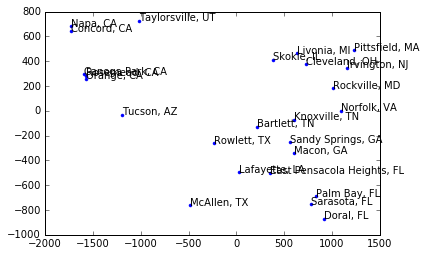

In [42]:
# And visualize the results!
plt.plot(pos[:,0],pos[:,1],'.')
for label,x,y in zip(rdf.columns.values,pos[:,0],pos[:,1]):
    plt.annotate(label,xy=(x,y))

Keep in mind that there's no solution here for orientaton, just relative position.

Finally, we might wish to export our results to another program for visualization.  <a href="https://gephi.org/">Gephi</a>, combined with the <a href="https://marketplace.gephi.org/plugin/mds-statistics/">Multidimensional Scaling</A> plugin can create a layout as well.

In [52]:
# First, grab the indices of just the upper right triangle (since it's symmetric)
ur_idx = np.triu_indices(len(D),1)

# And get the column and row coordinates of these
c,r = np.meshgrid(range(len(D)),range(len(D)))
c = c[ur_idx]
r = r[ur_idx]

# Turn them into a 1D version, and grab just those distances
c = c.ravel()
r = r.ravel()
d = D[r,c]

# And export those using pandas
out_df = pd.DataFrame({'source':rdf.columns.values[r],'target':rdf.columns.values[c],'distance':d})
out_df['source'] = rdf.columns.values[r]
out_df['target'] = rdf.columns.values[c]
out_df['distance'] = d
out_df['type'] = 'undirected'
out_df.to_csv('data/us-edges.csv',index=False)

<img src="data/mds-in-gephi.png" />

<h2>Would you like to know more?</h2>

<UL>
<LI>See the <a href="http://scikit-learn.org/stable/auto_examples/manifold/plot_mds.html">scikit learn examples</a> for more information on MDS in Python.</LI>
<LI><A href="http://www.wouterspekkink.org/?p=299">MDS with R and Gephi</A>
<LI><A HREF="https://marketplace.gephi.org/plugin/mds-statistics/">MDS</a> in <a href="https://gephi.org/">Gephi</A>
<LI>Read pretty much anything you can get your hands on by <a href="http://www.geog.ucsb.edu/~tobler/">Waldo Tobler</a>.
<LI>Grab the <a href="data/us-edges.gephi">gephi file</a> for the network shown above.
</UL>
